## **Introduction**

Putative Creode or p-Creode is an algorithm developed to map transitions between states. Particularly, p-Creode was developed to map multi-branched cellular differentiation pathways using single cell data. This notebook will give an overview of applying p-Creode to a synthetic data set.

## **Import Python Modules**

Before a python module or package can be accessed it has to be imported. Here the p-Creode package along with other common python packages for handling data sets and plotting are imported. All of these packages should have been installed when pcreode was installed. If any of the packages are not installed, pip install package should remedy the situation (for example: “pip install numpy” or if administrative privileges are needed for linux users “sudo pip install numpy”).

In [104]:
# imports the pcreode package
import pcreode
# matplotlib is a commonly used package for plotting
import matplotlib.pyplot as plt
# pandas is a package used for making the handling of large data sets easier 
import pandas as pd
# numpy is very common package for handling arrays and matrices
import numpy as np
# this line tells matplotlib to plot results inline with the current jupyter notebook
%matplotlib inline

p-Creode works on single-cell datasets that have been feature-selected.  For mass cytometry and multiplex imaging, which are candidate-based approaches, this step has been done implicity by selecting the candidate markers to measure. For these cases, one only has to normalize the data accordingly.  For scRNA-seq data, feature selection has to be done to eliminate genes whose expression patterns are random (considered as noise). There are multiple ways to do this automatically. We use the neighborhood variance ratio (NVR) approach. For a tutorial where we process raw count data into normalized feature-selected data, please visit: https://github.com/KenLauLab/pCreode/.

p-Creode assumes the data format as a matrix with cells represented as the rows and genes as the columns. Below (data_raw.head() output) is an example of the expected format.  

## **Load Colon Data Set**

In [105]:
file_nm = "../data/colon_test.csv"

The pandas (pd) read_csv function is used to read in our file. If the file path above is incorrect you will see the fail here. 

In [106]:
data_raw = pd.read_csv( file_nm)

It is always a good idea to check the formating of the file being read in. Using the pd.head() function we can look at the first 5 rows in the file. A common error when reading in a file is pandas using the wrong row as the header for the protein or gene names.

In [107]:
data_raw.shape

(1597, 415)

Remeber to always check to see if you data if loaded correctly.

In [108]:
data_raw.head()

,1500004A13Rik,1700017I07Rik,1810065E05Rik,2010109I03Rik,2200002D01Rik,2310079G19Rik,2810417H13Rik,4931406C07Rik,5330417C22Rik,Abcb1a,...,Unc80,Upp1,Uqcrb,Vil1,Wbp5,Wdr24,Xkr4,Ywhaq,Zfp644,Zg16
0,0.142480,0.14248,0.071419,0.0,0.14248,0.000000,0.00000,0.000000,0.350200,0.14248,...,0.0,0.000000,0.071419,0.142480,0.212830,0.071419,0.071419,0.350200,0.605610,5.28250
1,0.000000,0.00000,1.209900,0.0,0.50679,0.000000,0.00000,0.000000,0.000000,0.28969,...,0.0,0.794880,1.177300,0.175350,0.058717,0.961250,0.058717,0.400470,0.000000,0.50679
2,0.000000,0.00000,2.048200,0.0,1.04620,0.529470,0.00000,0.404770,0.000000,0.58919,...,0.0,0.647080,1.416900,0.467970,0.000000,0.206490,0.000000,0.069264,0.000000,1.04620
3,0.074067,0.00000,0.000000,0.0,0.00000,0.000000,0.49809,0.074067,0.220610,0.00000,...,0.0,0.074067,0.958410,0.074067,0.625600,1.598700,0.000000,0.292360,0.074067,0.62560
4,0.212340,0.00000,0.604340,0.0,0.77560,0.071251,0.00000,0.142140,0.071251,0.72046,...,0.0,0.142140,0.604340,0.543360,0.142140,0.775600,0.000000,0.349400,0.000000,0.66338


# Data Preprocessing

To remove excessive noise associated with single cell data sets we recommend preprocessing the data prior to applying p-Creode. If your data has already been preprocessed (ie. PCA or diffusion maps) to your satisfaction you can skip ahead to the Density section. Here, we will be processing the data using principal component analysis (PCA). 

To start, read data to be analyzed into pcreode's PCA class, this class is a convenient way to apply PCA. Input to pcreode.PCA must be in the format of a pandas DataFrame. Now, all of the functions under the PCA class can be accessed through the data_pca call.

In [109]:
data_pca = pcreode.PCA( data_raw)

Once initialized, PCA can be performed by simply calling get_pca(). This call will perform the PCA but will not return anything. We can access the results through calls to the PCA class.

In [110]:
data_pca.get_pca()

We can now plot the explained variance for each principal component. The variable xlim can be used to set the x-axis range for the plot.

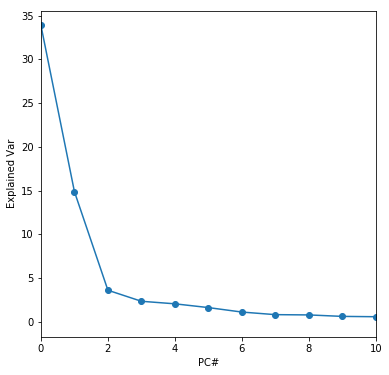

In [111]:
data_pca.pca_plot_explained_var( xlim=(0,10))

The number of PCs can be set using the pca_set_components function. This function will return the reduced data set for the number of components selected. The number of PCs are chosen such that noise is removed and without the loss of too much definition in the data distributions. A common way of doing this is to look for an elbow in the explained variance plot above (which is not always very evident, like in the one above). An alternative method is to plot the data in PC space and only keep the number of PCs that provide  structure/shape in the data cloud (unstructured data would appear as a sphere of data points – keeping additional PCs will add to noise).

In [112]:
pca_test_data = data_pca.pca_set_components( 5)

(Text(0.5,0,'PC5'), Text(0,0.5,'PC4'))

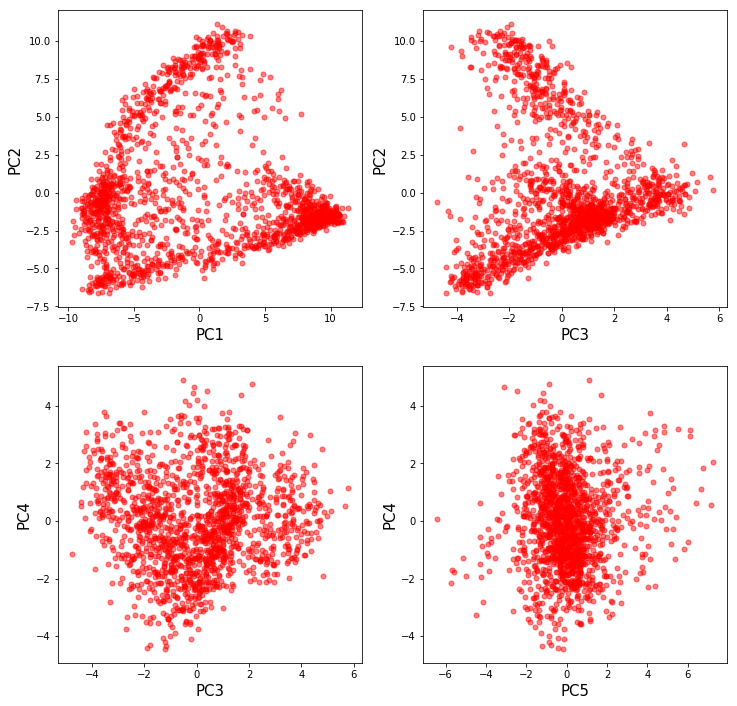

In [113]:
fig = plt.figure( figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
cc = 'r'
ax1.scatter( pca_test_data[:,0], pca_test_data[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( pca_test_data[:,2], pca_test_data[:,1], alpha=0.5, s=25, c=cc)
ax3.scatter( pca_test_data[:,2], pca_test_data[:,3], alpha=0.5, s=25, c=cc)
ax4.scatter( pca_test_data[:,4], pca_test_data[:,3], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)
ax3.set_xlabel("PC3", fontsize=15), ax3.set_ylabel("PC4", fontsize=15)
ax4.set_xlabel("PC5", fontsize=15), ax4.set_ylabel("PC4", fontsize=15)

Judging from the plots above, there is little to no gain in structure of the data distribution beyond the PC3, evident by the lack of definition in plots containing PC4 and above. Therefore, there is likely little gain in using more than 3 principal components.

In [114]:
pca_reduced_data = data_pca.pca_set_components( 3)

# **Below this point no parameters have been set, good luck!!**

# Density Calculation

Now that the preprocessing has been performed, the density of each data point can be calculated. This process is started by calling the pcreode.Density class using the PCA processed data. The format of the data set for the Density class should be a numpy array. 

In [ ]:
dens = pcreode.Density( pca_reduced_data)

To calculate the densities of the data points, the radius of inclusion must first be established. For each data point the density will be set by counting the number of other data points contained within the radius, where the radius is centered on the data point in question. Setting the radius is a very important step. The radius should not be so large that the range of densities is limited and not so small that noisy data points have the same density as non noisy data points. A good starting radius is can be generated by comparing the distance to the nearest neighbor for all data points. The nearest_neighbor_hist() function will return a hist of all nearest neighbors distances and a best guess for the radius.

In [ ]:
best_guess = dens.nearest_neighbor_hist( )

In [ ]:
density = dens.get_density( radius=10.0)
dens.density_hist( n_bins=50)

In [ ]:
fig = plt.figure( figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = density
ax1.scatter( pca_reduced_data[:,0], pca_reduced_data[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( pca_reduced_data[:,2], pca_reduced_data[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)

# Setting down-sampling parameters

Now the radius is set the noise and target density parameters used for down-sampling the data can be set. The noise variable controls which data points will be removed and the target density is the desired density of output. The target density can be used to control the computational overhead by limiting the number of cells in the downsampled data set. The largest dataset we could run was ~14000 cells on my current machine (See Specs in Methods).

In [ ]:
noise = 1.0
target = 100.0

In [ ]:
downed, downed_ind = pcreode.Down_Sample( pca_reduced_data, density, noise, target)

In [ ]:
fig = plt.figure( figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = density[downed_ind]
ax1.scatter( downed[:,0], downed[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( downed[:,2], downed[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)

While setting the down-sampling parameters, it is always a good idea to compare the downsampled data set with the original.

In [ ]:
fig = plt.figure( figsize=(16,8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cc = density
ax1.scatter( pca_reduced_data[:,0], pca_reduced_data[:,1], alpha=0.5, s=25, c=cc)
ax2.scatter( pca_reduced_data[:,2], pca_reduced_data[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlabel("PC1", fontsize=15), ax1.set_ylabel("PC2", fontsize=15)
ax2.set_xlabel("PC3", fontsize=15), ax2.set_ylabel("PC2", fontsize=15)

# Obtaining p-Creode graphs

Now that all the parameters have been set we can run the main p-Creode algorithm and produce a series of graphs. We suggest you run at least 100, but we will only run 10 here. A directory should be created to hold the graph outputs and the path to your new directory should be updated for the pCreode function call. (Again, change the directory to your settings here) PC users will have to use Windows directory formatting, do not omit the backslash "/" at the end.

In [ ]:
file_path = "/home/herrinca/Desktop/Test/"

In [ ]:
num_runs = 10

In [ ]:
out_graph, out_ids = pcreode.pCreode( data=pca_reduced_data, density=density, noise=noise, 
                                      target=target, file_path=file_path, num_runs=num_runs)

# p-Creode graph scoring

Finally we can score the graph outputs to find the most representative graph. The file path should be the same as above and the number of graphs (num_graphs) should be set to 10 or the number you want to score if you ran more or less than 10 graphs above. The data variable should be set to the same data set used in the pCreode function. The final output will be a ranking of graph IDs from first to worst based how respresentative p-Creode thinks they are of the data.

In [ ]:
graph_ranks = pcreode.pCreode_Scoring( data=pca_reduced_data, file_path=file_path, num_graphs=10)

# Graph plotting

Looking at the ranked graphs above (results will differ with each) we can select the best graph from the run, in my case the graph ID was graph 8. Plotting the graphs can be a little frustrating given igraph's plot function (We are currently working on better plotting function). The the plotting function will produce a random graph visualization with each plot unless we seed the random number generator (the representation will be different but the graph will not change). We can seed the generator with the seed variable within the plot_save_graph function. It will sometimes take a few tries to get a graph that is easy to read (more tries are generally needed with graphs containing more nodes). [Here](https://github.com/KenLauLab/pCreode/blob/master/notebooks/Elane.png) is an example of what your output graph should look like. See paper for explanation of results. 

In [ ]:
gid = 0#graph_ranks[0] # this will select the first graph ID in the ranking from above
print gid

To start analyzing the outputs from pcreode, we begin by initializing the Analysis class from pcreode. The gid is the graph run you are interested in viewing, in this sepecific case it is the most representive graph. The file_path, data, and denstiy arguments should be the same as was used to produce the graph. 

In [ ]:
analysis = pcreode.Analysis( file_path=file_path, graph_id=gid, data=pca_reduced_data, density=density, noise=noise)

To view the graph plots with different overlays the plot_save_graph function from the Analysis class is used. The seed variable will likely have to be sampled at different values. The overlay variable should be the analyte you are interested in visualizing on the graph. This argument comes from the orignal data set if preprocessing (PCA, etc) was used to prior to building the graphs. The file_out is the name of the .png file you would like to output into the file_path directory. upper_range is a normalization variable that will vary analyte to analyte and should be changed to maximize the node color range.   

In [ ]:
seed = 1

In [ ]:
analysis.plot_save_graph( seed=seed, overlay=data_raw['Muc2'], file_out='Muc2', upper_range=1.25)

In [ ]:
analysis.plot_save_graph( seed=seed, overlay=data_raw['Reg4'], file_out='Reg4', upper_range=2.5)

In [ ]:
analysis.plot_save_graph( seed=seed, overlay=data_raw['Krt20'], file_out='Krt20', upper_range=2.5)

Qualitative data (i.e. time points, independent clustering ids, etc) can also be overlayed onto a graph. To demonstrate this feature K-means clustering of the data will be overlayed. Because igraph plotting is the bane of my existence, the figure legend is an independent graph and will not be included in the saved .png file in the output directory, but it can be easly saved by right clicking.

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 3
clust_model = KMeans(n_clusters=num_clusters, random_state=5).fit( pca_reduced_data)
qual_data = clust_model.labels_
qual_data

In [ ]:
str_qual_data = qual_data.astype( str)
str_qual_data

In [ ]:
analysis.plot_save_qual_graph( seed=seed, overlay=str_qual_data, file_out='3_clusters_overlay')

To produce a labeled graph with node graph node ids, use code below; a more readable output will be in the output directory. 

In [ ]:
analysis.plot_save_graph( seed=seed, overlay=data_raw['CD34'], file_out='CD34_with_ids', upper_range=2.5, node_label_size=18)

Analyte dynamics can be viewed using the function below. A "root" node will have to be supplied, all possible trajectories will be shown with the given overlay. Red vertical dotted lines indicate a branch point and the black dotted vertical lines the end of the trajectory. The solid black lines for each bar indicated the standard error for all the cells assigned to that node (cells are assigned to the node closest to them). The root id is best found using the id overlay on the graph plots, the png file in the output directory is likely more readable. 

In [ ]:
analysis.plot_analyte_dynamics( data_raw['CD34'], 2)

In [ ]:
analysis.plot_analyte_dynamics( data_raw.ELANE, 2)

To produce a csv files for export containing all analyte dynamics for each trajectory use the function call below. A csv file for each trajectory will be created, trajectory labels are the same as above. To produce the graph overlays and trajectory analysis all of the cells that are over the noise threshold are binned into one of the selected graph nodes. This function call will also produce a file containing the id to which each cell was binned.  

In [ ]:
analysis.get_complete_analyte_gene_trajectories( data_raw, 0, file_out='Myeloid')

If you would like to escape the limitations of python graph plotting you can export an weighted adjacency matrix, which then can be up loaded into more capable graphing softwares like Cytoscape.

In [ ]:
w_adj = pcreode.return_weighted_adj( pca_reduced_data, file_path, gid)
w_adj